In [4]:
import itertools, copy, random, json, torch, timm, torch.nn as nn
from torch.utils.data import DataLoader, random_split
from torch.cuda.amp import GradScaler, autocast
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from torchvision import datasets, transforms
from pathlib import Path
from collections import Counter
import pandas as pd, matplotlib.pyplot as plt, seaborn as sns
plt.style.use("ggplot")

### Config

In [5]:
class CFG:
    seed          = 42
    # data
    LABELS        = ["Unripe", "Early Ripening", "Ripe", "Fully Ripe", "Overripe"]
    img_size      = 299
    batch_size    = 32
    num_classes   = len(LABELS)
    mean          = (0.485, 0.456, 0.406)
    std           = (0.229, 0.224, 0.225)
    # training
    epochs        = 50
    early_patience= 8
    # optimiser (baseline)
    optimizer     = "Adam"
    lr            = 1e-3
    loss_fn       = "CrossEntropy"
    momentum      = 0.9
    wd            = 1e-6
    # system
    num_workers   = 2
    device        = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    # model
    base_model    = "inception_v3"            # timm name


SEARCH = {
    "optimizer": ["Adam", "SGD", "Adagrad"],
    "lr"       : [1e-3, 5e-3, 1e-4],
    "loss_fn"  : ["CrossEntropy", "WeightedCrossEntropy"],
    "batch_size": [16, 32, 64]
}
N_SAMPLES = 12 

random.seed(CFG.seed); 
torch.manual_seed(CFG.seed)

HISTORIES = {}          # run_id ➜ list of val_acc per epoch
LR_HIST  = {}           # optional, if you step LR manually

### Data Pipeline

In [6]:
DATA_ROOT = Path("./data/processed_data/")
train_tf = transforms.Compose([
    transforms.Resize((CFG.img_size, CFG.img_size)),
    transforms.RandomHorizontalFlip(), transforms.RandomRotation(20),
    transforms.ToTensor(), transforms.Normalize(CFG.mean, CFG.std)
])
val_tf = transforms.Compose([
    transforms.Resize((CFG.img_size, CFG.img_size)),
    transforms.ToTensor(), transforms.Normalize(CFG.mean, CFG.std)
])

full_ds   = datasets.ImageFolder(DATA_ROOT, transform=train_tf)
class_hist= Counter([y for _, y in full_ds])

n_total   = len(full_ds)
n_test    = int(0.10 * n_total)
n_val     = int(0.10 * n_total)
n_train   = n_total - n_val - n_test

train_ds, val_ds, test_ds = random_split(full_ds, [n_train, n_val, n_test])
val_ds.dataset.transform  = val_tf
test_ds.dataset.transform = val_tf

def make_loader(split_ds, bs, shuffle):
    return DataLoader(split_ds, batch_size=bs, shuffle=shuffle,
                      num_workers=CFG.num_workers,
                      pin_memory=torch.cuda.is_available())

### Helpers

In [7]:
def build_model(cfg, freeze_backbone=True):
    model = timm.create_model(cfg.base_model,
                              pretrained=True,
                              num_classes=cfg.num_classes).to(cfg.device)

    if freeze_backbone:
        # timm names the head 'fc' for InceptionV3
        head = model.fc
        for p in model.parameters():     # freeze everything …
            p.requires_grad = False
        for p in head.parameters():      # … except the head
            p.requires_grad = True
    return model

def make_criterion(cfg):
    if cfg.loss_fn == "CrossEntropy":
        return nn.CrossEntropyLoss()
    # weighted CE
    counts  = torch.tensor([class_hist[i] for i in range(cfg.num_classes)],
                           dtype=torch.float32)
    weights = (1.0 / counts) * len(counts) / counts.sum()
    return nn.CrossEntropyLoss(weight=weights.to(cfg.device))

def make_optimizer(cfg, model):
    if cfg.optimizer == "Adam":
        return torch.optim.Adam(model.parameters(), lr=cfg.lr, weight_decay=cfg.wd)
    if cfg.optimizer == "SGD":
        return torch.optim.SGD(model.parameters(), lr=cfg.lr,
                               momentum=cfg.momentum, weight_decay=cfg.wd)
    return torch.optim.Adagrad(model.parameters(), lr=cfg.lr, weight_decay=cfg.wd)

USE_CUDA = torch.cuda.is_available()

def train_one_epoch(model, loader, crit, opt, scaler, device):
    model.train(); running = 0
    for X, y in loader:
        X, y = X.to(device), y.to(device)
        opt.zero_grad()
        with autocast(enabled=USE_CUDA):
            loss = crit(model(X), y)
        scaler.scale(loss).backward(); scaler.step(opt); scaler.update()
        running += loss.item() * X.size(0)
    return running / len(loader.dataset)

@torch.no_grad()
def evaluate(model, loader, device):
    model.eval(); y_true, y_pred = [], []
    for X, y in loader:
        X = X.to(device)
        y_true += y.tolist()
        y_pred += model(X).argmax(1).cpu().tolist()
    return accuracy_score(y_true, y_pred)

### Baseline Run

In [8]:
def run_baseline(cfg):
    tr_loader = make_loader(train_ds, cfg.batch_size, shuffle=True)
    va_loader = make_loader(val_ds,   cfg.batch_size, shuffle=False)
    model = build_model(cfg)
    crit  = make_criterion(cfg); opt = make_optimizer(cfg, model)
    scaler= GradScaler(enabled=USE_CUDA)

    best_acc, best_ep = 0, -1
    for epoch in range(cfg.epochs):
        train_one_epoch(model, tr_loader, crit, opt, scaler, cfg.device)
        val_acc = evaluate(model, va_loader, cfg.device)
        if val_acc > best_acc: best_acc, best_ep = val_acc, epoch
        if epoch - best_ep > cfg.early_patience: break
    torch.save(model.state_dict(), "baseline.pt")
    json.dump({"optimizer": cfg.optimizer, "lr": cfg.lr,
               "loss_fn": cfg.loss_fn, "batch_size": cfg.batch_size,
               "val_acc": best_acc}, open("baseline_metrics.json", "w"))
    print(f"Baseline val-acc={best_acc:.4f}")

run_baseline(copy.deepcopy(CFG))

Baseline val-acc=0.9646


### Random Search

In [9]:
def random_search_space(search, k, seed=42):
    random.seed(seed)
    keys, vals = zip(*search.items())
    combos = list(itertools.product(*vals))
    for tup in random.sample(combos, k):
        yield dict(zip(keys, tup))

results = []
for hp in random_search_space(SEARCH, N_SAMPLES):
    cfg = copy.deepcopy(CFG)
    for k, v in hp.items(): setattr(cfg, k, v)
    print("▶", hp)

    tr_loader = make_loader(train_ds, cfg.batch_size, True)
    va_loader = make_loader(val_ds,   cfg.batch_size, False)

    model  = build_model(cfg)
    crit   = make_criterion(cfg)
    opt    = make_optimizer(cfg, model)
    scaler = GradScaler(enabled=USE_CUDA)

    best_acc, best_ep = 0, -1
    for epoch in range(cfg.epochs):
        train_one_epoch(model, tr_loader, crit, opt, scaler, cfg.device)
        val_acc = evaluate(model, va_loader, cfg.device)
        if val_acc > best_acc:
            best_acc, best_ep = val_acc, epoch
            torch.save(model.state_dict(), "inceptionv3_model.pt")
            best_cfg = hp
        if epoch - best_ep > cfg.early_patience: break
    results.append({**hp, "val_acc": best_acc})

# save results
df = pd.DataFrame(results).sort_values("val_acc", ascending=False).reset_index(drop=True)
# df.to_csv("./inceptionv3/search_results.csv", index=False)
print("\nTop-5 random runs\n", df.head())


▶ {'optimizer': 'Adagrad', 'lr': 0.001, 'loss_fn': 'WeightedCrossEntropy', 'batch_size': 32}
▶ {'optimizer': 'Adam', 'lr': 0.005, 'loss_fn': 'CrossEntropy', 'batch_size': 32}
▶ {'optimizer': 'Adam', 'lr': 0.001, 'loss_fn': 'CrossEntropy', 'batch_size': 32}
▶ {'optimizer': 'Adagrad', 'lr': 0.005, 'loss_fn': 'WeightedCrossEntropy', 'batch_size': 64}
▶ {'optimizer': 'Adam', 'lr': 0.0001, 'loss_fn': 'WeightedCrossEntropy', 'batch_size': 64}
▶ {'optimizer': 'Adam', 'lr': 0.0001, 'loss_fn': 'WeightedCrossEntropy', 'batch_size': 16}
▶ {'optimizer': 'Adam', 'lr': 0.0001, 'loss_fn': 'CrossEntropy', 'batch_size': 64}
▶ {'optimizer': 'Adam', 'lr': 0.005, 'loss_fn': 'CrossEntropy', 'batch_size': 64}
▶ {'optimizer': 'Adam', 'lr': 0.005, 'loss_fn': 'CrossEntropy', 'batch_size': 16}
▶ {'optimizer': 'Adagrad', 'lr': 0.005, 'loss_fn': 'CrossEntropy', 'batch_size': 32}
▶ {'optimizer': 'SGD', 'lr': 0.0001, 'loss_fn': 'WeightedCrossEntropy', 'batch_size': 32}
▶ {'optimizer': 'Adam', 'lr': 0.001, 'loss_fn'

### Bar Chart

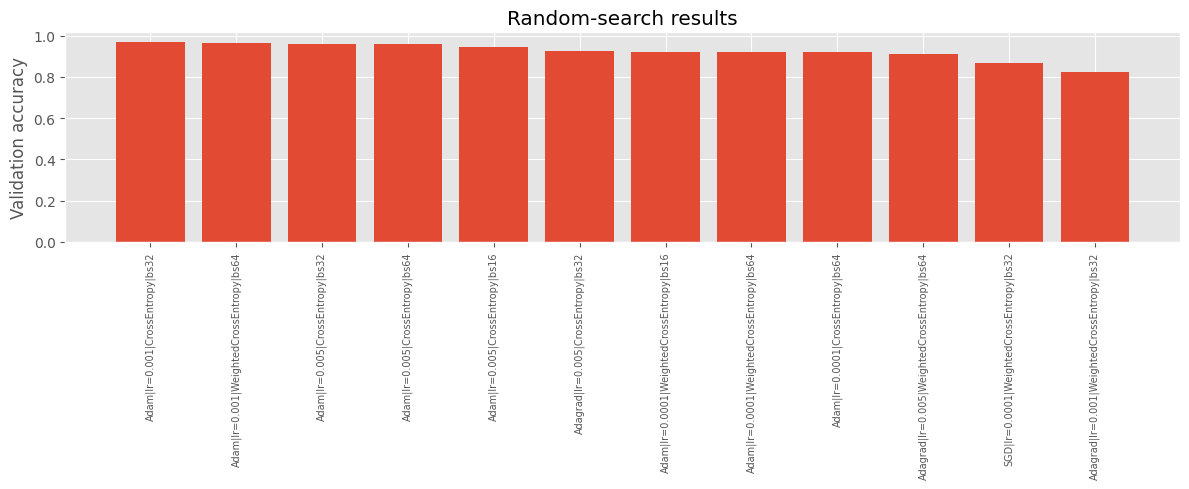

In [16]:
plt.figure(figsize=(12,5))
plt.bar(range(len(df)), df["val_acc"])
plt.xticks(range(len(df)),
           [f'{r.optimizer}|lr={r.lr}|{r.loss_fn}|bs{r.batch_size}'
            for _, r in df.iterrows()],
           rotation=90, ha="center", fontsize=7)
plt.ylabel("Validation accuracy")
plt.title("Random-search results")
plt.tight_layout(); 
#plt.savefig("./inceptionv3/random_search_bar.png", dpi=300); 
plt.show()

### Evaluate best model on TEST set & confusion matrix


Best random-search model test-acc = 0.9641


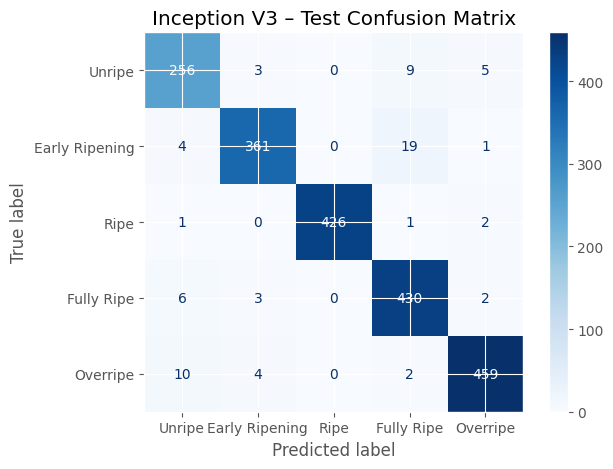

In [15]:
best_model = build_model(CFG)
best_model.load_state_dict(torch.load("inceptionv3_model.pt"))

te_loader = make_loader(test_ds, CFG.batch_size, False)
test_acc  = evaluate(best_model, te_loader, CFG.device)
print(f"\nBest random-search model test-acc = {test_acc:.4f}")

# confusion matrix
y_true, y_pred = [], []
best_model.eval()
with torch.no_grad():
    for X, y in te_loader:
        X = X.to(CFG.device)
        y_true += y.tolist()
        y_pred += best_model(X).argmax(1).cpu().tolist()

cm = confusion_matrix(y_true, y_pred)
ConfusionMatrixDisplay(cm, display_labels=CFG.LABELS).plot(cmap="Blues")
plt.title("Inception V3 – Test Confusion Matrix")
plt.tight_layout(); 
plt.show()
